In [1]:
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm
import pymc.sampling_jax
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, auc, average_precision_score, precision_recall_curve
from sklearn.calibration import CalibrationDisplay
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

%load_ext watermark
%watermark -n -u -v -iv -w -p sklearn

Last updated: Sat Mar 23 2024

Python implementation: CPython
Python version       : 3.9.18
IPython version      : 8.12.0

sklearn: 1.4.0

matplotlib: 3.8.2
seaborn   : 0.13.2
pymc      : 5.10.3
pandas    : 2.2.0
numpy     : 1.26.3
arviz     : 0.17.0

Watermark: 2.4.3



In [2]:
import os

os.chdir("D:/Programming/project1/Transmission_probability/method3_enveloppes/v_PyMC/")

In [3]:
df = pd.read_excel("Input2/under_1m/enveloppe4_0.1_pivot.xlsx")
df1 = pd.read_excel("Input2/under_1m/enveloppe4_0.1.xlsx")
y = df1["infected"].to_numpy()

In [4]:
# Pre-calculate unique combinations of experiment and contact_duration
unique_combinations = df[['experiment', 'contact_duration']].drop_duplicates()

# Convert to a list of tuples for iteration
unique_combinations = [tuple(x) for x in unique_combinations.to_numpy()]

In [5]:
%%time
model = pm.Model()
with pm.Model() as model:
    # Priors
    p0 = pm.Beta('p0', alpha=1, beta=1)
    lambda_ = pm.LogNormal('lambda', mu = -1, sigma=0.1)

    # Loop through data
    for e, c in unique_combinations:
        df_temp = df[(df['experiment'] == e) & (df['contact_duration'] == c)]
        ids = df_temp['cap_ID'].unique()
            
        # Iterate over unique cap_IDs
        for _, group in df_temp.groupby('cap_ID'):
            distances = group['distance'].values
            times = group['time'].values
            p_temp = (1 - (p0 * pm.math.exp(-lambda_ * distances))) ** times   
            p_i = pm.math.prod(p_temp)
            p = 1 - p_i
                
    # Likelihood
    y_true = pm.Bernoulli('y_obs', p = p, observed=y)

    inits = {'p0': 0.001, 'lambda': 0.1}

CPU times: total: 172 ms
Wall time: 220 ms


In [6]:
%%time
with model:
    trace = pm.sampling.jax.sample_blackjax_nuts(draws=10000, tune=1000, chains=10, target_accept=0.95, initvals=inits, random_seed=42)

Compiling...
Compilation time = 0:00:03.299558
Sampling...
Sampling time = 0:00:04.679801
Transforming variables...
Transformation time = 0:00:00.099828


CPU times: total: 8.02 s
Wall time: 8.3 s


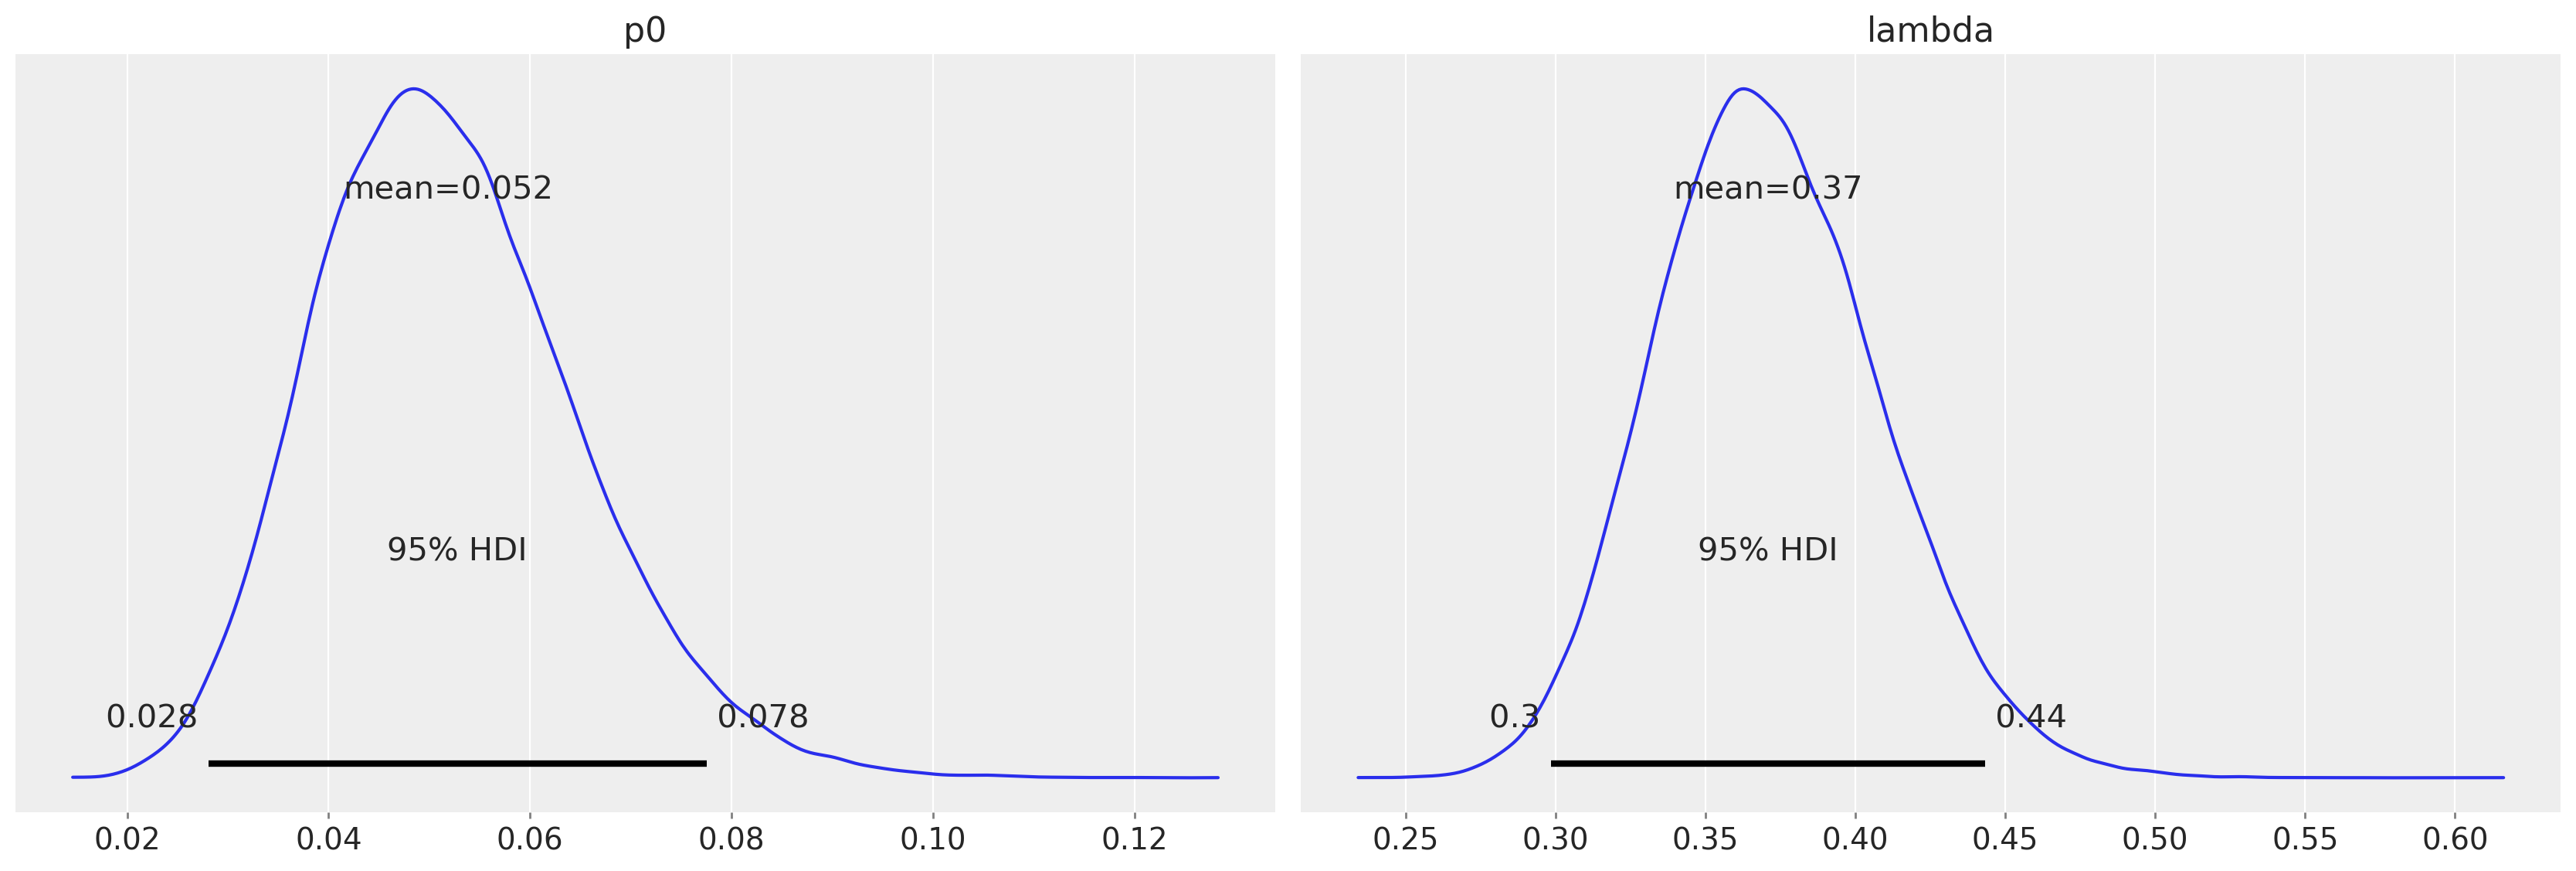

In [7]:
az.plot_posterior(trace, var_names=["p0", "lambda"], hdi_prob=.95);

In [8]:
az.summary(trace, round_to=4, hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p0,0.0518,0.0129,0.0281,0.0775,0.0000,0.0000,64986.4013,55258.3132,1.0001
lambda,0.3710,0.0373,0.2984,0.4432,0.0001,0.0001,64460.0356,61051.2424,1.0001


In [9]:
with open('Output2/trace_enveloppe_1m_0.1.pkl', 'wb') as f:
    pickle.dump(trace, f)

In [10]:
p0_sample = trace.posterior["p0"].stack(sample=("chain", "draw")).values
p0_sample = np.random.choice(p0_sample, size=1000)
lambda_sample = trace.posterior["lambda"].stack(sample=("chain", "draw")).values
lambda_sample = np.random.choice(lambda_sample, size=1000)

In [11]:
# Initialize the list for predictions
pred = []

# Iterate over samples
for j in range(len(lambda_sample)):
    a = lambda_sample[j]
    b = p0_sample[j]
    pred_parametre = []
    
    # Iterate over unique combinations of experiment and contact_duration
    for e, c in unique_combinations:
        df_temp = df[(df['experiment'] == e) & (df['contact_duration'] == c)]
        ids = df_temp['cap_ID'].unique()
        
        # Iterate over unique cap_IDs
        for id in ids:
            p_i = 1
            datai = df_temp[df_temp['cap_ID'] == id]
            distances = datai['distance'].values
            times = datai['time'].values
            
            # Vectorized calculation of p_temp
            p_temp = (1 - (b * np.exp(a * distances))) ** times
            
            # Product of probabilities for the cap_ID
            p_i = np.prod(p_temp)
            
            # Append the final calculation for the cap_ID
            pred_parametre.append(1 - p_i)
    
    # Append predictions for this sample
    pred.append(pred_parametre)

In [20]:
simulations_proba = pd.DataFrame({f'y_pred{i+1}': sublist for i, sublist in enumerate(pred)})

simulations_bernoulli = simulations_proba.map(lambda prob: np.random.binomial(1, prob))

In [21]:
proportions = simulations_bernoulli.mean(axis=1)
df_proportions = pd.DataFrame(proportions, columns=['y_pred'])
df_proportions.insert(0, 'y_true', y)
simulations_proba.insert(0, 'y_true', y)

In [22]:
y_true = df_proportions['y_true']
y_pred = df_proportions['y_pred']

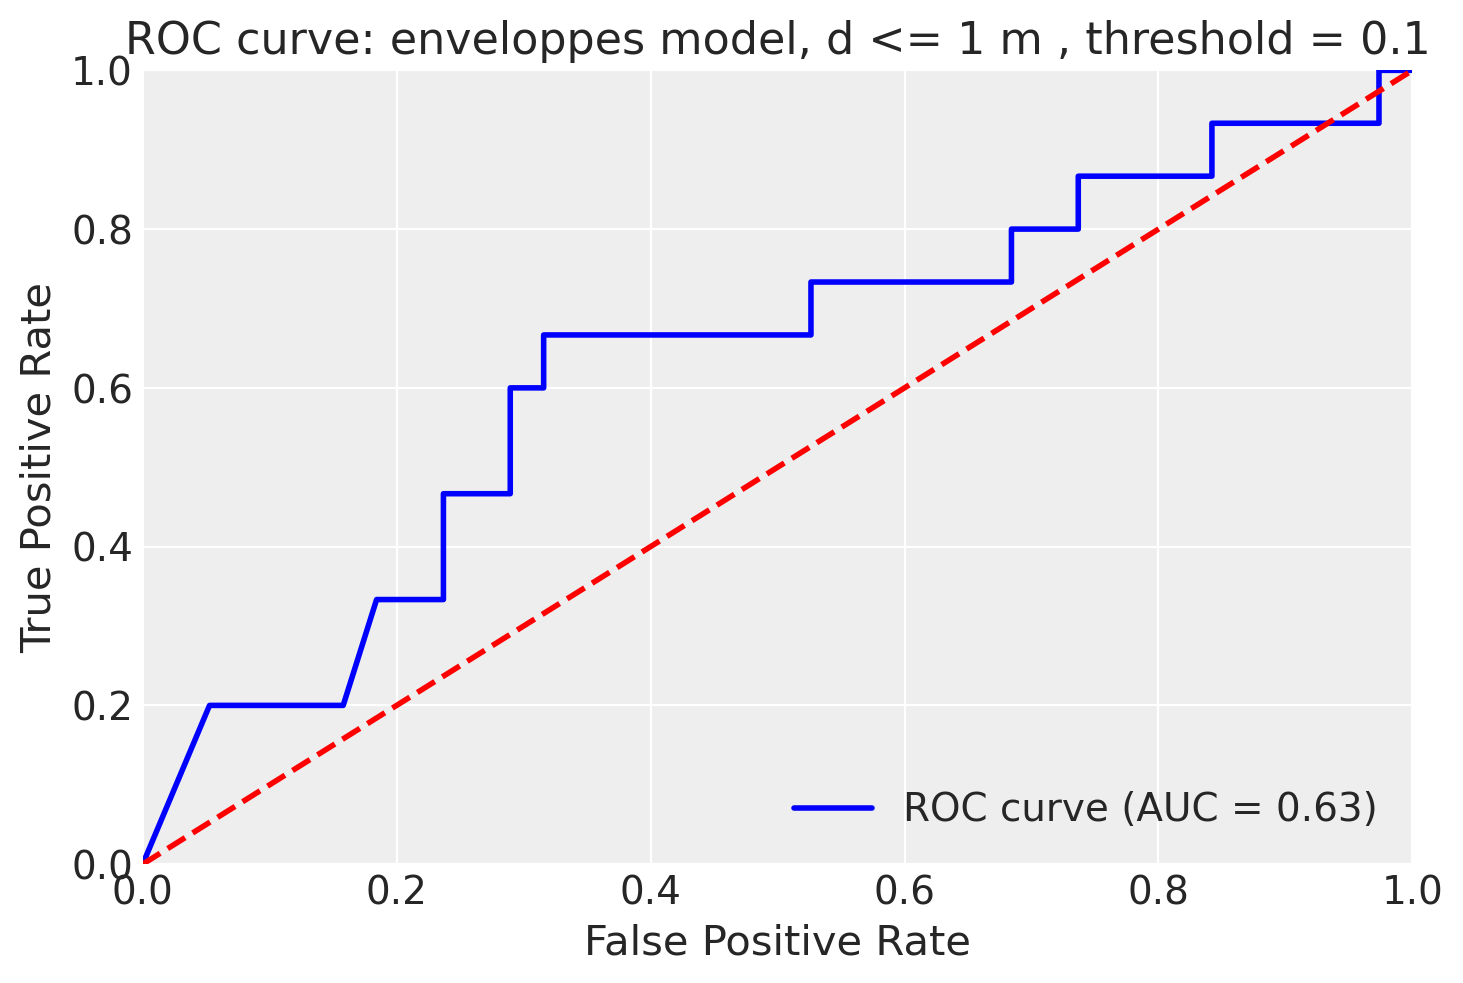

In [23]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve: enveloppes model, d <= 1 m , threshold = 0.1')
plt.legend(loc="lower right")
plt.show()

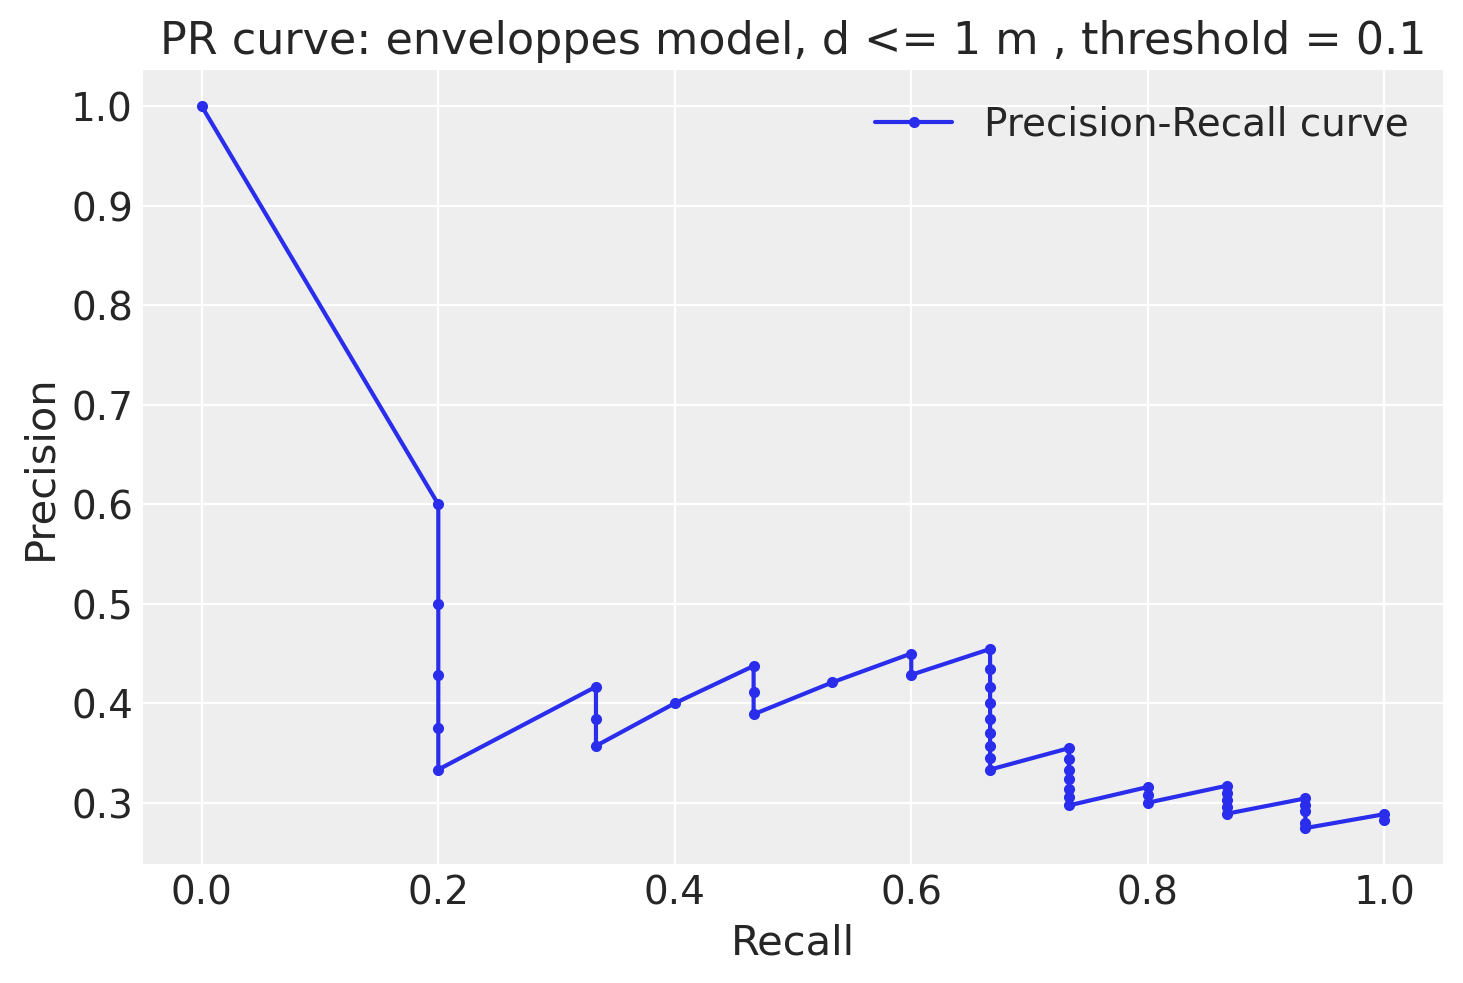

In [25]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

plt.plot(recall, precision, marker='.', label= "Precision-Recall curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve: enveloppes model, d <= 1 m , threshold = 0.1')
plt.legend()
plt.show()

In [26]:
print("Avg Precision: {:.2f}".format(average_precision_score(y_true, y_pred)))

Avg Precision: 0.43


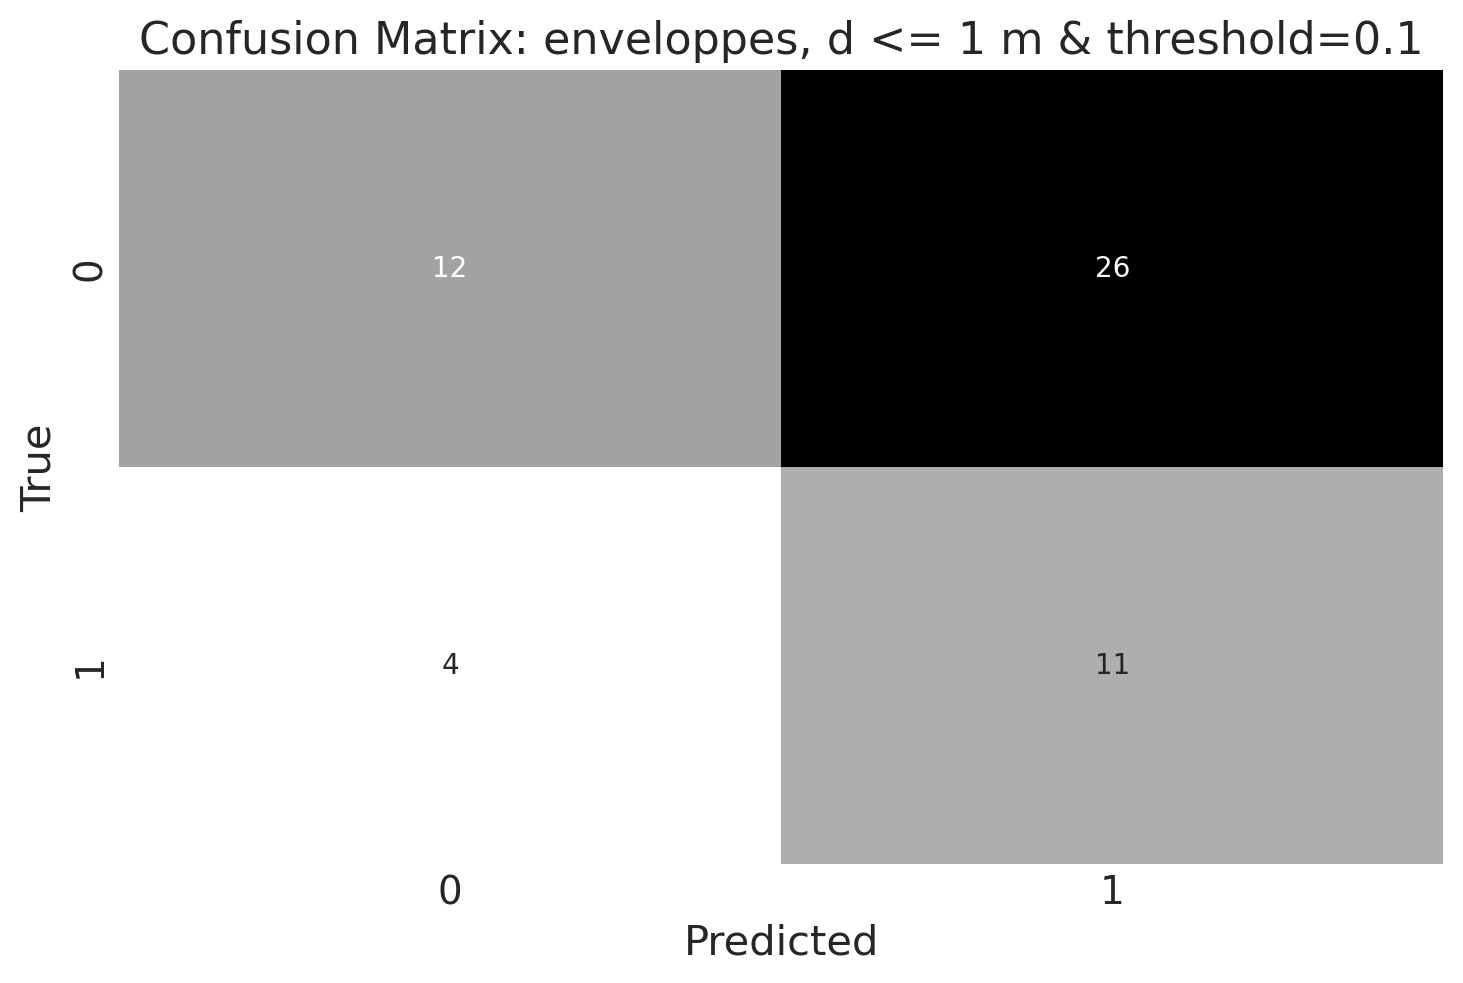

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert probabilities to binary predictions
y_pred_binary = [1 if p > 0.5 else 0 for p in y_pred]

# Now you can compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)

# Visualize confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='binary', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix: enveloppes, d <= 1 m & threshold=0.1')
plt.show()

In [28]:
df1['animal_ID'] = df1['experiment'].astype(str) + '_' + df1['contact_duration'].astype(str) + '_' + df1['cap_ID'].astype(str)

In [29]:
df_proportions.insert(0, 'animal_ID', df1['animal_ID'])

In [30]:
df_proportions.sort_values(by=['y_true', 'animal_ID'], ascending= True, inplace=True)
df_proportions.to_excel('Output2/df_proportions_1m_0.1.xlsx', index=False)

In [31]:
df_proportions = pd.read_excel("Output2/df_proportions_1m_0.1.xlsx")

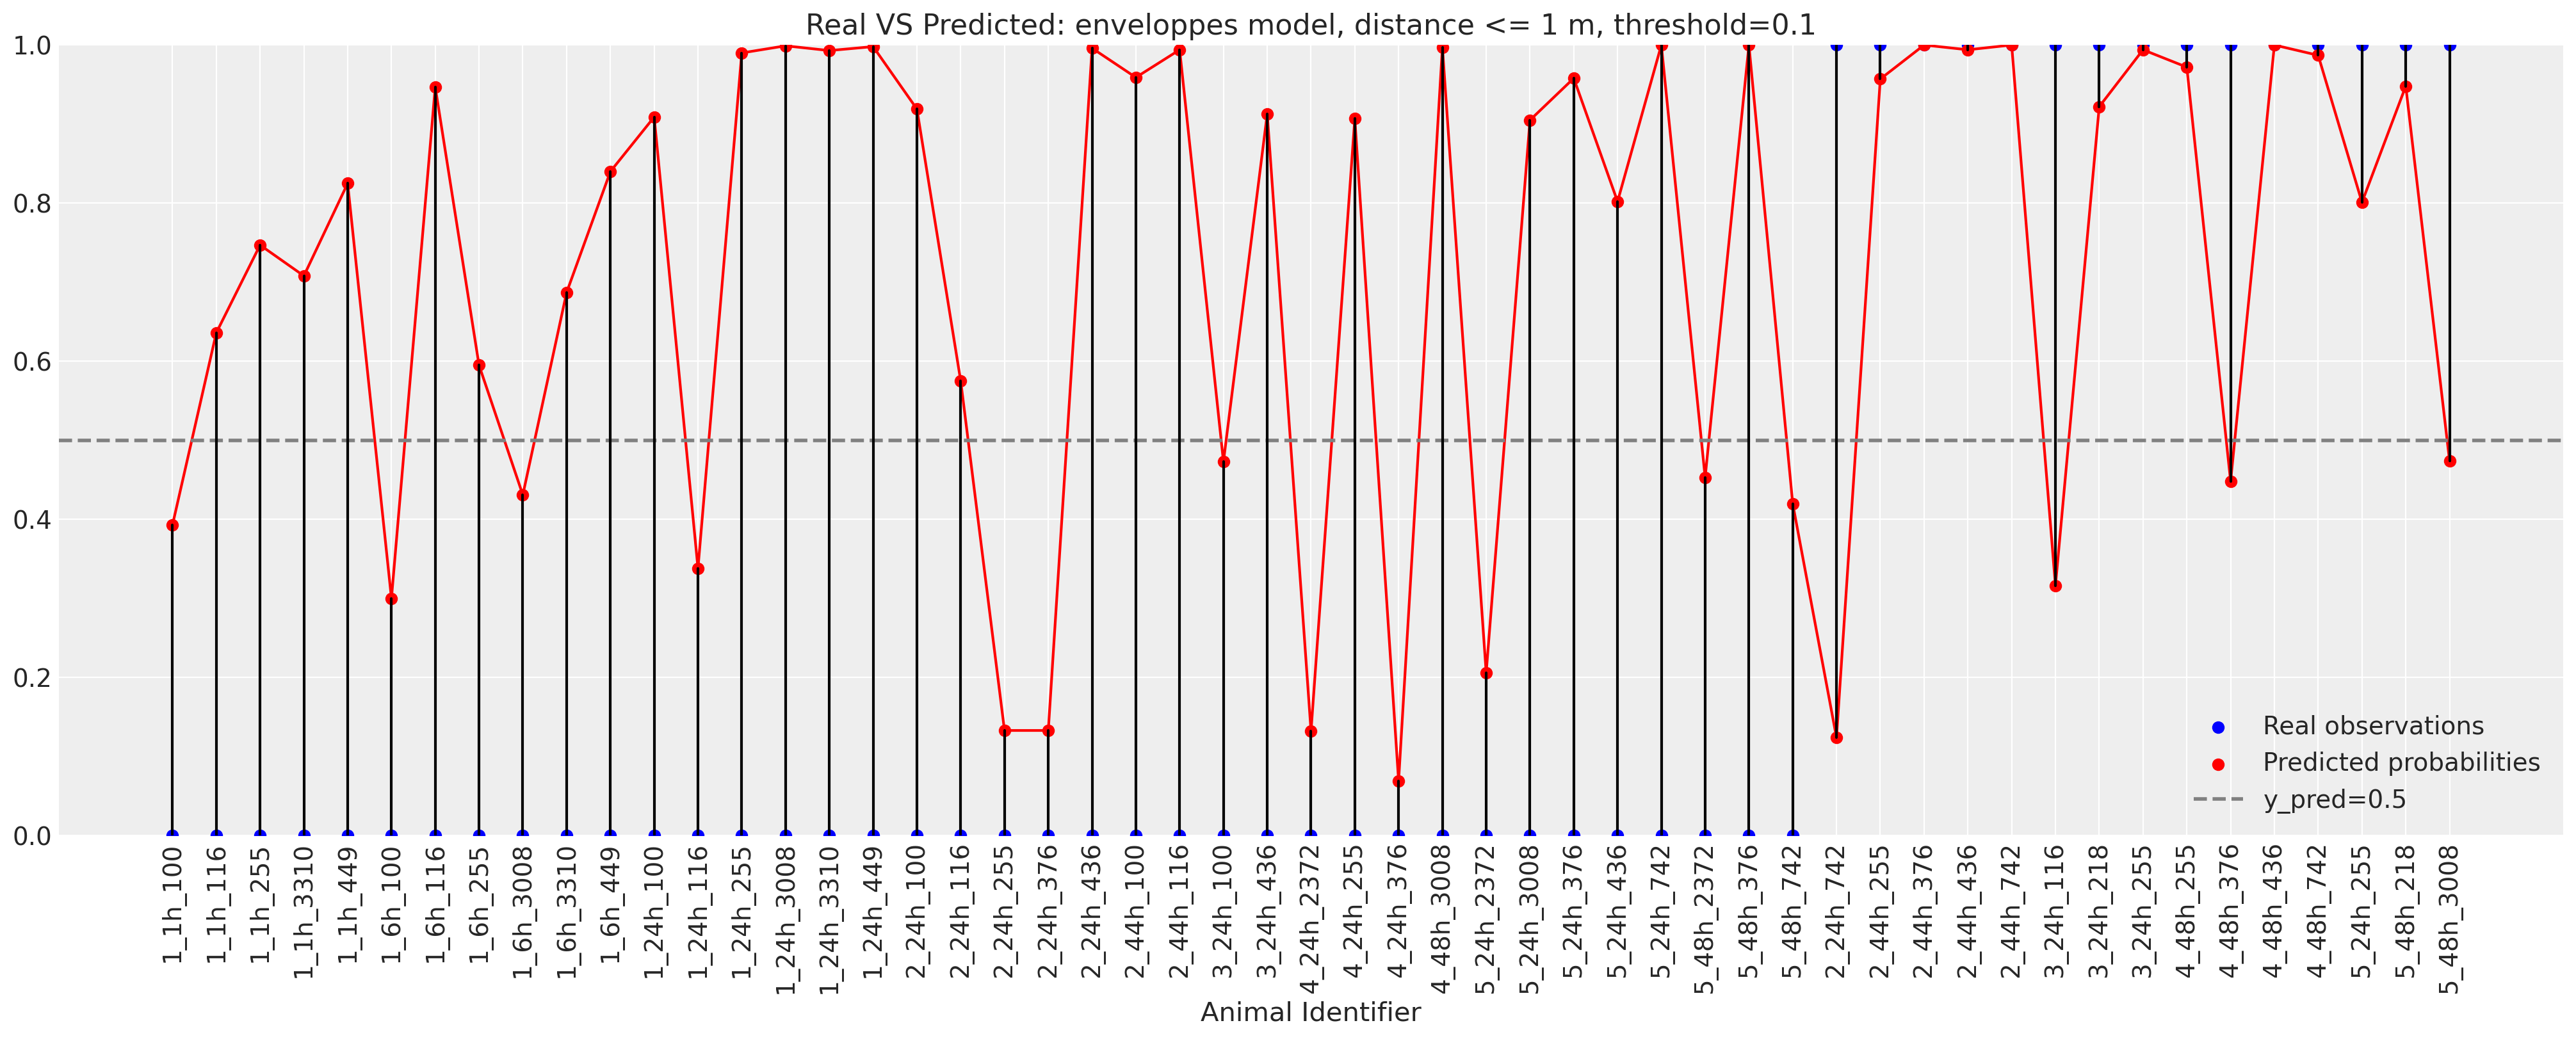

In [32]:
# Créer une figure et un axe
fig, ax = plt.subplots(figsize = (20, 8))

# Tracer les points pour y_true et y_pred
ax.scatter(df_proportions['animal_ID'], df_proportions['y_true'], color='blue', label='Real observations')
ax.scatter(df_proportions['animal_ID'],df_proportions['y_pred'], color='red', label='Predicted probabilities')
ax.plot(df_proportions['animal_ID'], df_proportions['y_pred'], color='red')
ax.axhline(0.5, color='gray', lw=2, linestyle='--', label= 'y_pred=0.5')

# Tracer les boîtes entre y_true et y_pred
for i in range(len(df_proportions)):
    ax.plot([df_proportions['animal_ID'].iloc[i]]*2, [df_proportions['y_true'].iloc[i], df_proportions['y_pred'].iloc[i]], color='black')

# Définir les limites de l'axe des y
ax.set_ylim([0, 1])

for label in ax.get_xticklabels():
    label.set_rotation(90)

# Ajouter une légende
ax.legend()
plt.title("Real VS Predicted: enveloppes model, distance <= 1 m, threshold=0.1")
plt.xlabel("Animal Identifier")

plt.show()

In [14]:
# Créer le DataFrame
simulations = pd.DataFrame({f'y_pred{i+1}': sublist for i, sublist in enumerate(pred)})

simulations.insert(0, 'y_true', y)

In [15]:
y_true = simulations['y_true']

In [16]:
def plot_roc_curve(true_y, y_prob):

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    auc = roc_auc_score(true_y, y_prob)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:0.4f})')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve: enveloppes 1m , seuil = 0.1')
    plt.legend(loc="lower right")

In [17]:
aucs = []

# Boucle sur chaque colonne d'estimations
for col in simulations.columns[1:] : # Commencer à partir de la deuxième colonne car la première est y_true
    y_pred = simulations[col]
    auc = roc_auc_score(y_true, y_pred)
    aucs.append(auc)


In [18]:
# Trouver l'indice du maximum dans la liste d'AUC
indice_max_auc = np.argmax(aucs)

# Récupérer la colonne d'estimation avec le maximum d'AUC
col_max_auc = simulations.columns[indice_max_auc + 1]  # +1 pour compenser la première colonne (y_true)

# Afficher la colonne d'estimation avec le maximum d'AUC
print(f"La colonne avec le maximum d'AUC est : {col_max_auc}")

La colonne avec le maximum d'AUC est : y_pred2


In [19]:
mean_auc = np.mean(aucs)
median_auc = np.median(aucs)

print("mean auc:", mean_auc)
print("median auc:", median_auc)

q1 = np.quantile(aucs, 0.25)
q3 = np.quantile(aucs, 0.75)

if q3 == q1: 
   print("Not enough data")
else:
   iqr = q3 - q1  
   lower = q1 - 1.5 * iqr
   upper = q3 + 1.5 * iqr 
   conf_interval = (lower, upper)

   print(conf_interval)

mean auc: 0.5981151515151514
median auc: 0.5984848484848485
Not enough data


In [20]:
y_pred = simulations['y_pred2']

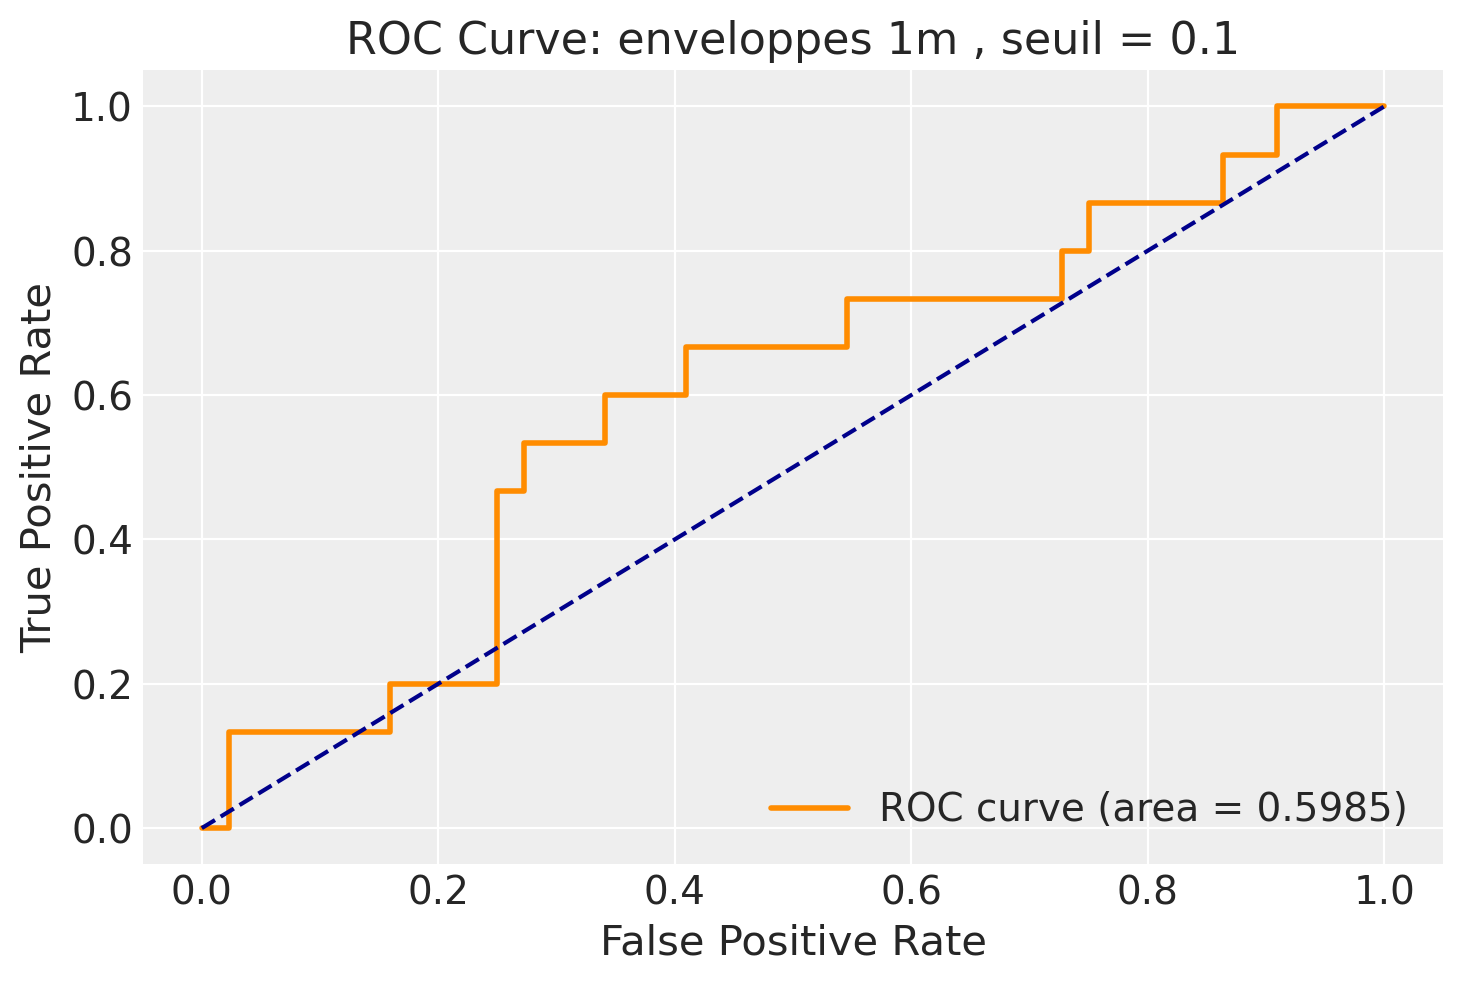

In [21]:
plot_roc_curve(y_true, y_pred)

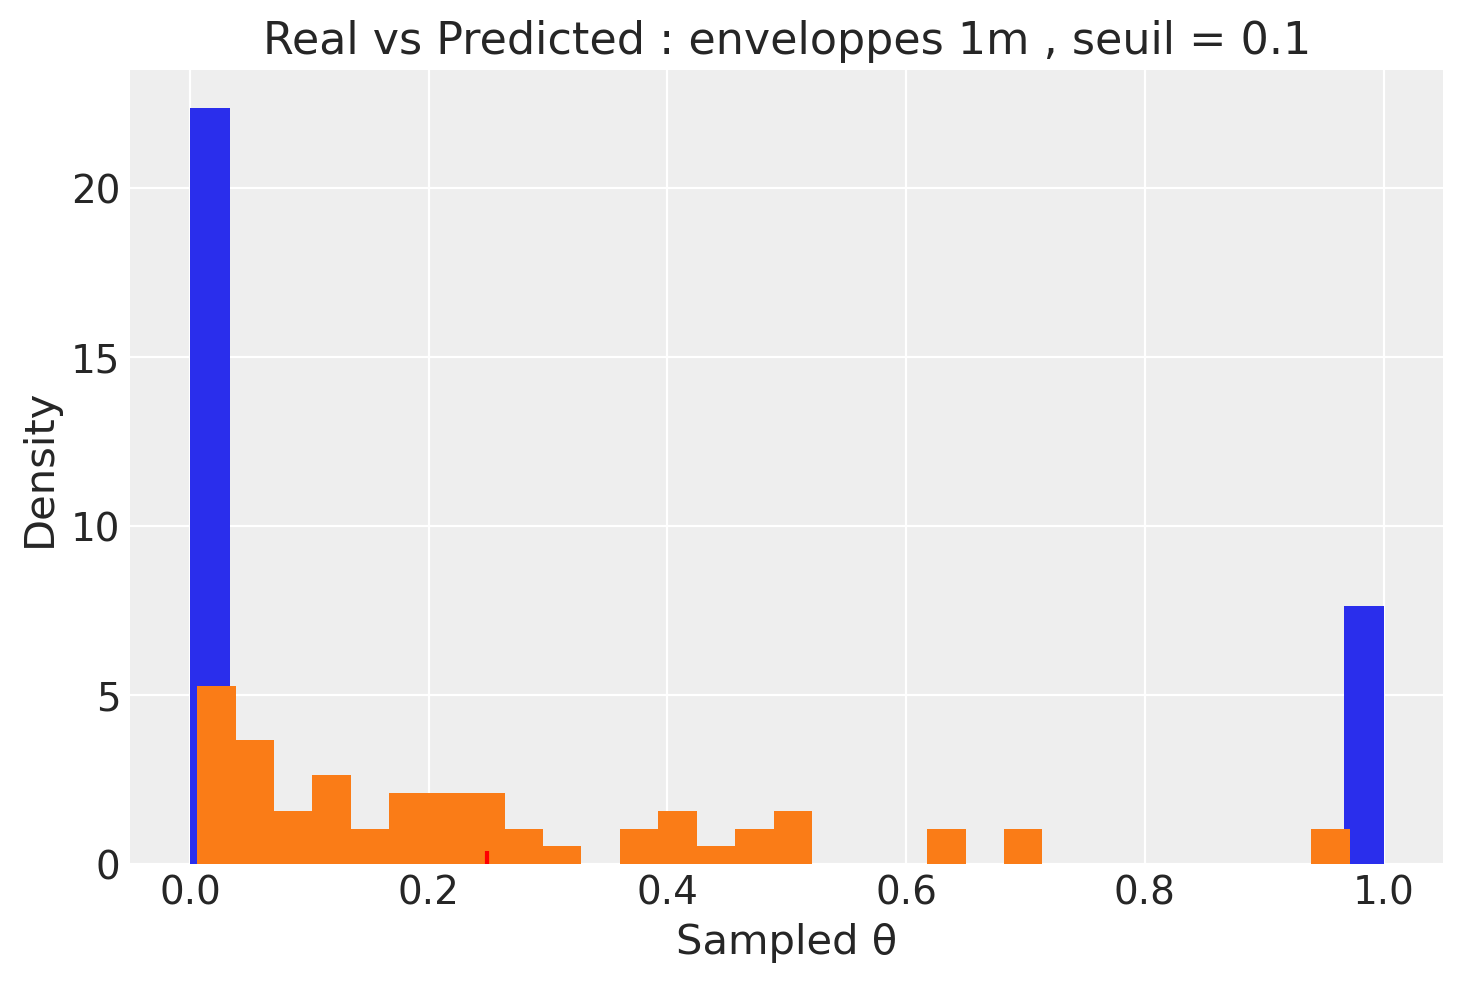

In [22]:
# Plot histogram  
plt.hist(y_true, bins=30, density=True)
plt.hist(y_pred, bins=30, density=True)
plt.vlines(y_pred.mean(), 0, 0.4, colors='r') 

plt.xlabel('Sampled θ')  
plt.ylabel('Density')
plt.title('Real vs Predicted : enveloppes 1m , seuil = 0.1')
   
plt.show()

In [23]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true, y_pred > 0.5) 
print(accuracy)

0.6949152542372882


In [24]:
from sklearn.metrics import precision_score, recall_score  

precision = precision_score(y_true, y_pred > 0.5)  
recall = recall_score(y_true, y_pred > 0.5)

print(precision, recall)

0.2857142857142857 0.13333333333333333


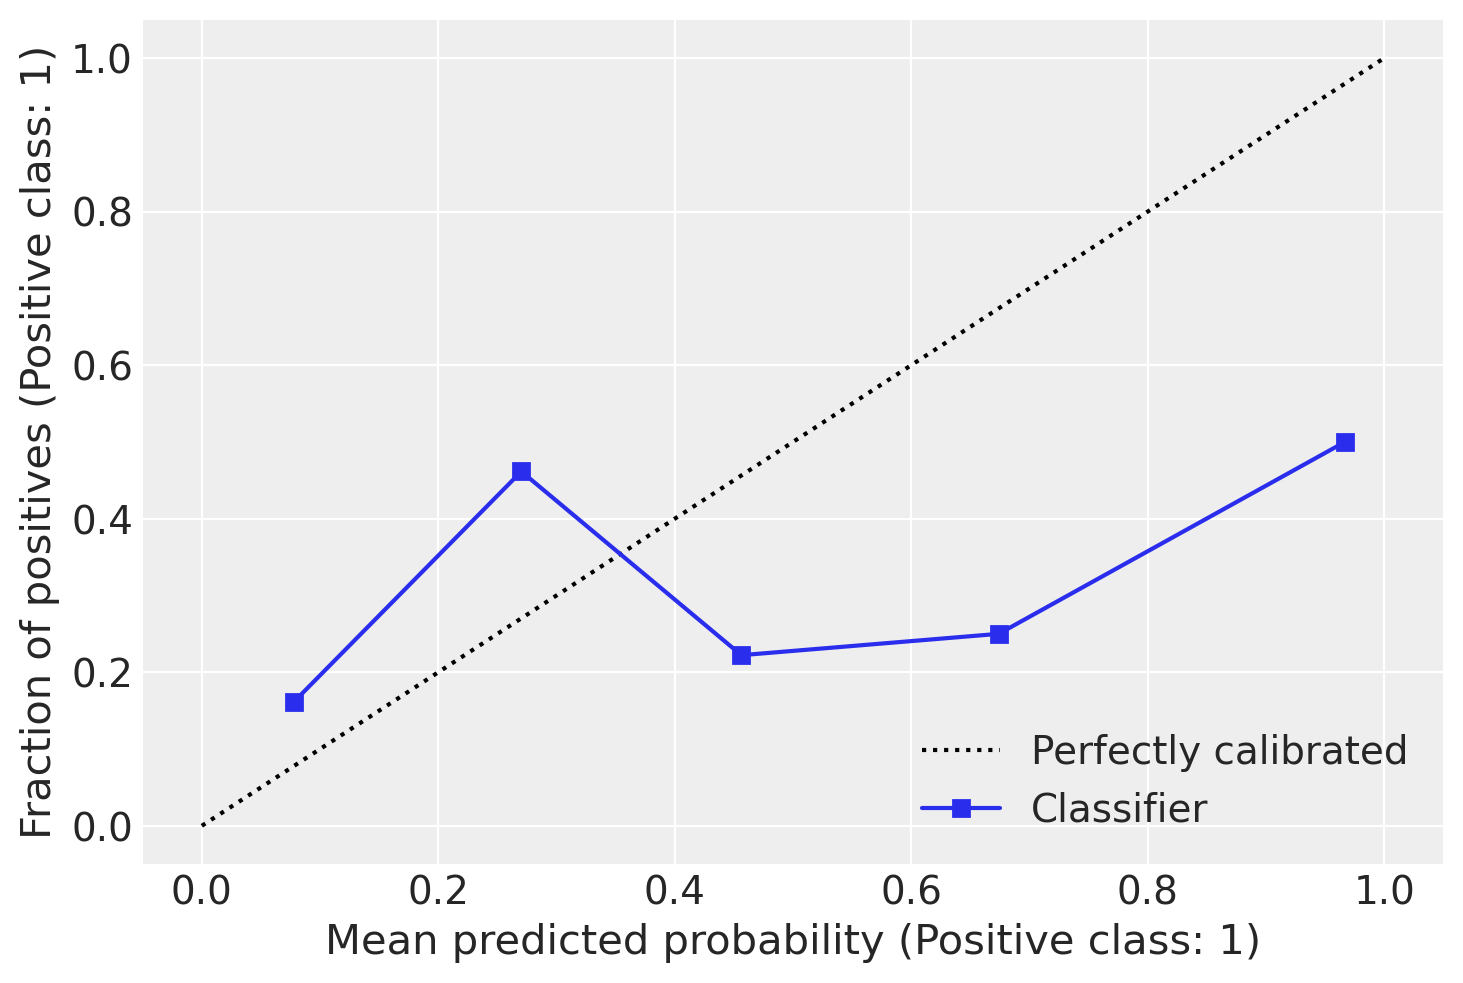

In [25]:
from sklearn.calibration import CalibrationDisplay

CalibrationDisplay.from_predictions(y_true, y_pred)

# Posterior analysis

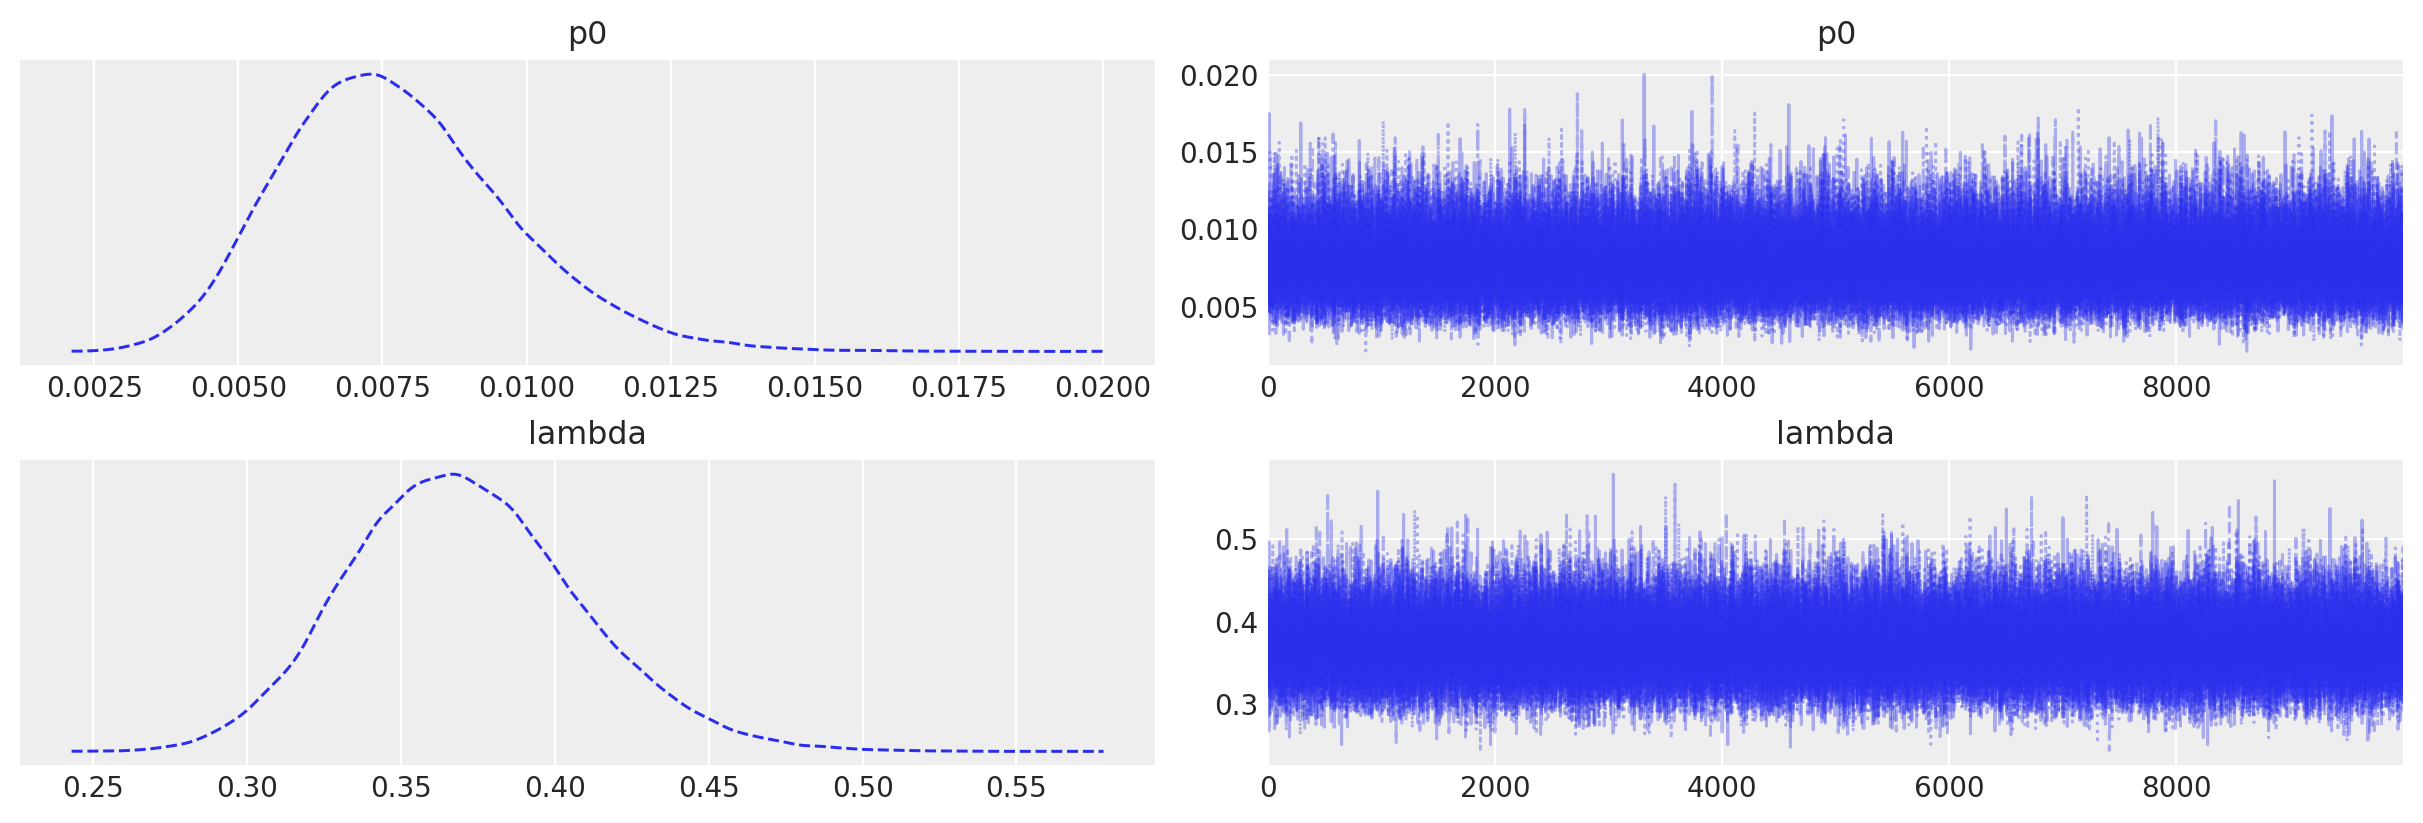

In [28]:
az.plot_trace(trace, combined=True);

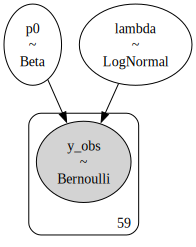

In [30]:
pm.model_to_graphviz(model)

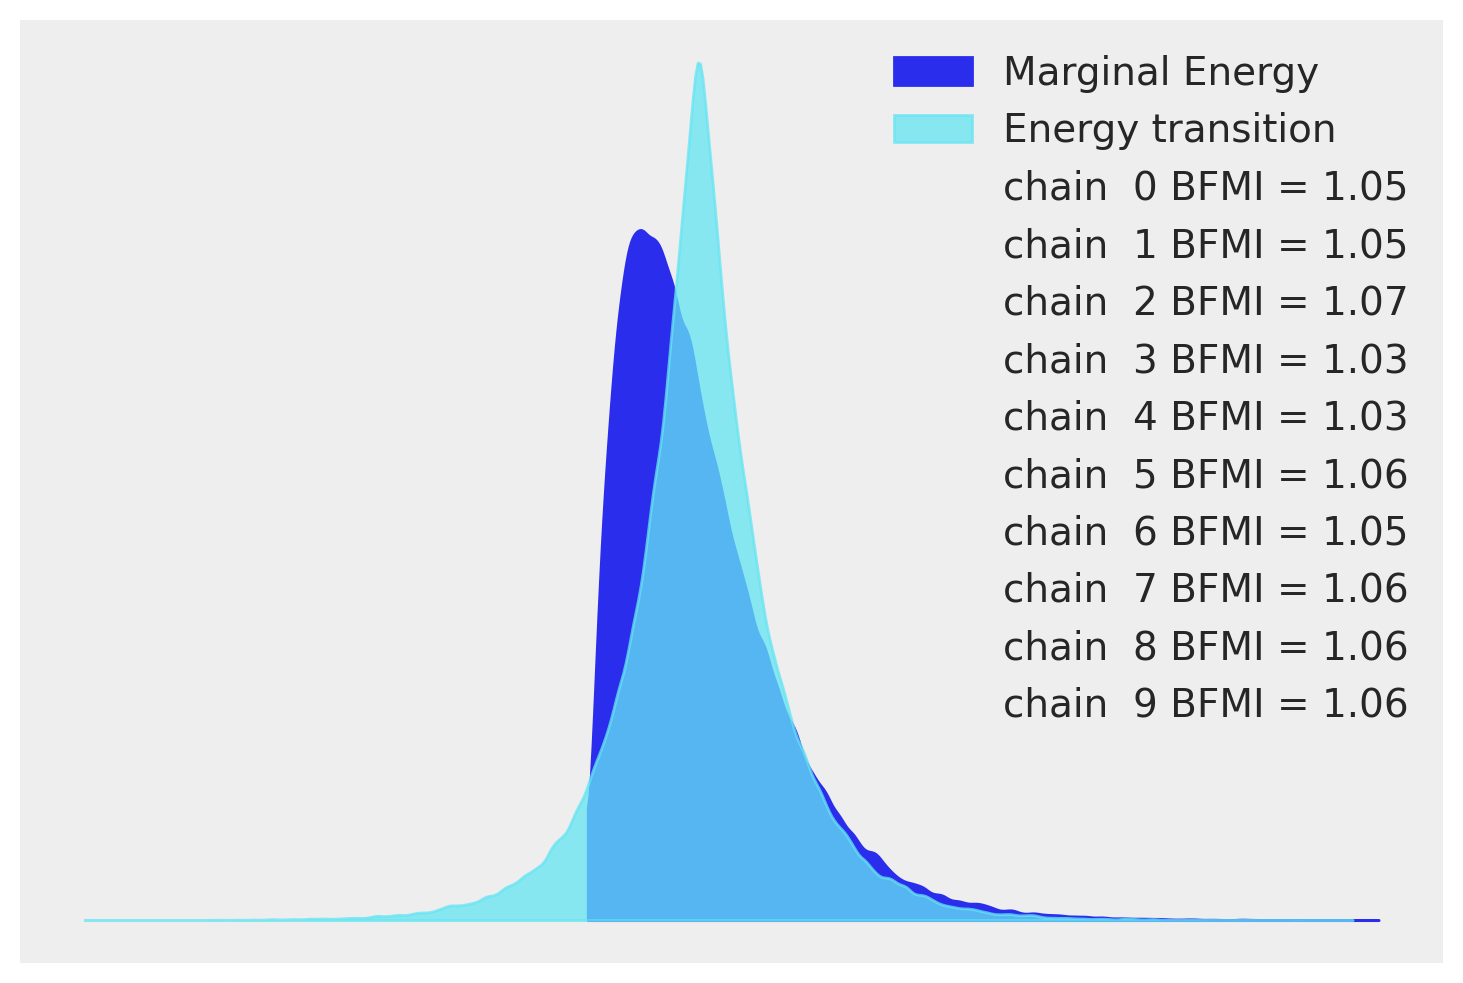

In [31]:
az.plot_energy(trace);

# Model log-likelihood

In [32]:
with model:
    pm.compute_log_likelihood(trace)

In [33]:
model_loo = az.loo(trace)

model_loo

Computed from 100000 posterior samples and 59 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -34.47     3.53
p_loo        0.99        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       59  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [34]:
model_waic = az.waic(trace)

model_waic

Computed from 100000 posterior samples and 59 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -34.46     3.53
p_waic        0.99        -

In [35]:
# Generate posterior predictive samples
with model:
    pm.sample_posterior_predictive(trace, random_seed=42, extend_inferencedata=True)

Sampling: [y_obs]


In [36]:
trace.posterior_predictive

<xarray.Dataset>
Dimensions:      (chain: 10, draw: 10000, y_obs_dim_2: 59)
Coordinates:
  * chain        (chain) int32 0 1 2 3 4 5 6 7 8 9
  * draw         (draw) int32 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999
  * y_obs_dim_2  (y_obs_dim_2) int32 0 1 2 3 4 5 6 7 ... 51 52 53 54 55 56 57 58
Data variables:
    y_obs        (chain, draw, y_obs_dim_2) int64 1 1 1 0 1 0 1 ... 0 0 0 1 0 0
Attributes:
    created_at:                 2024-02-02T13:26:42.215375
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.10.3

c:\Users\manhi\anaconda3\envs\tf\lib\site-packages\arviz\plots\ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
c:\Users\manhi\anaconda3\envs\tf\lib\site-packages\arviz\plots\ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


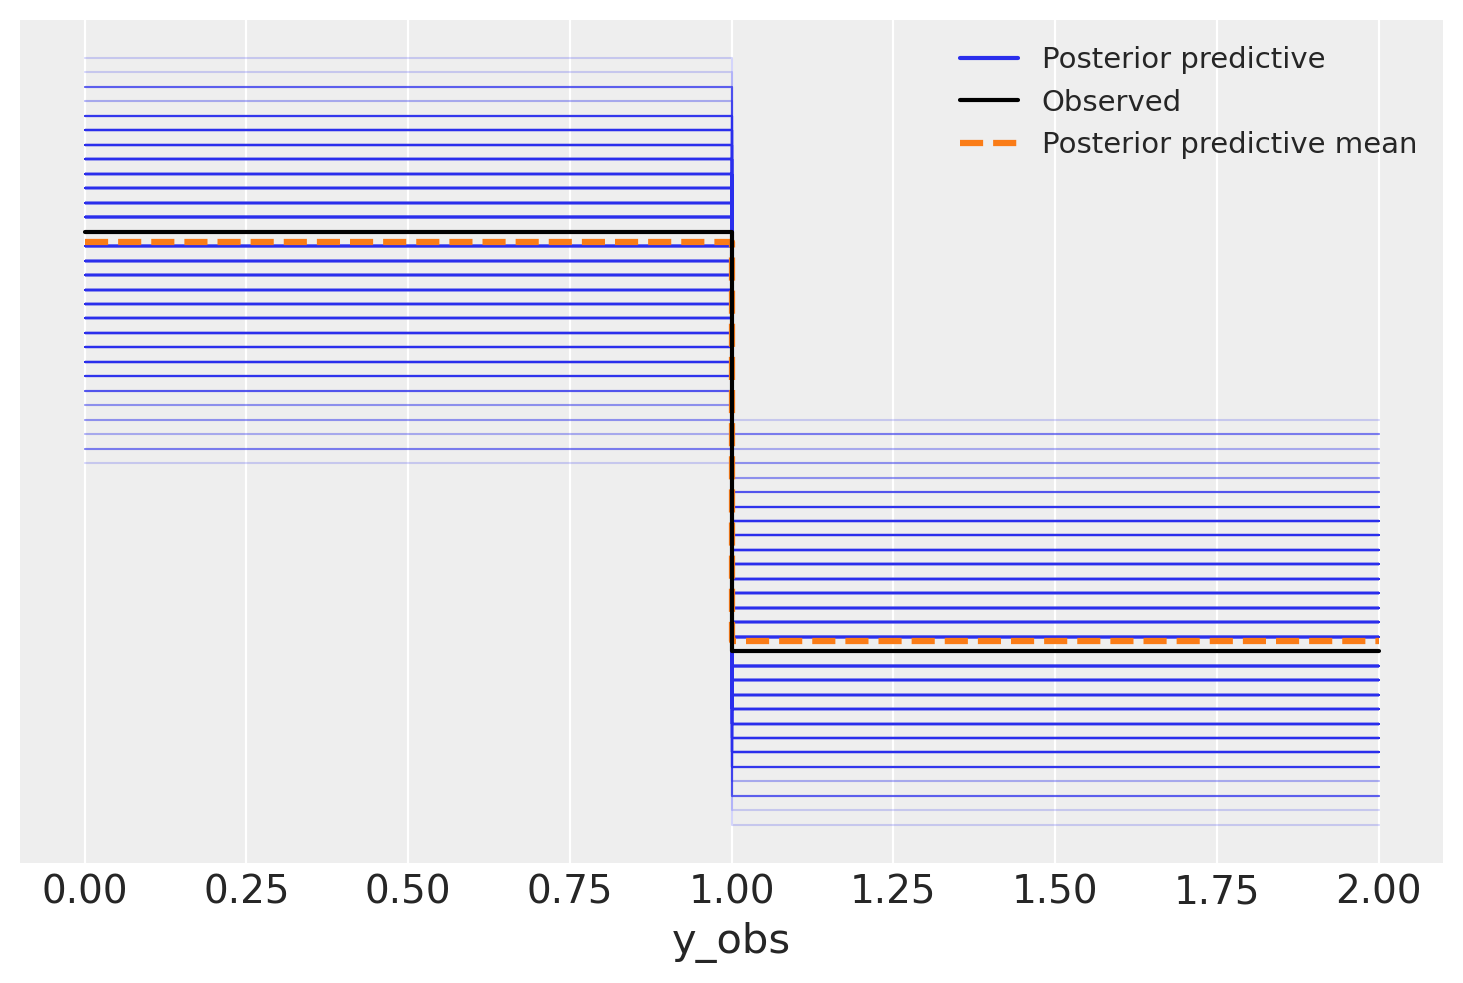

In [37]:
az.plot_ppc(trace, num_pp_samples=1000, kind = 'kde', group="posterior");

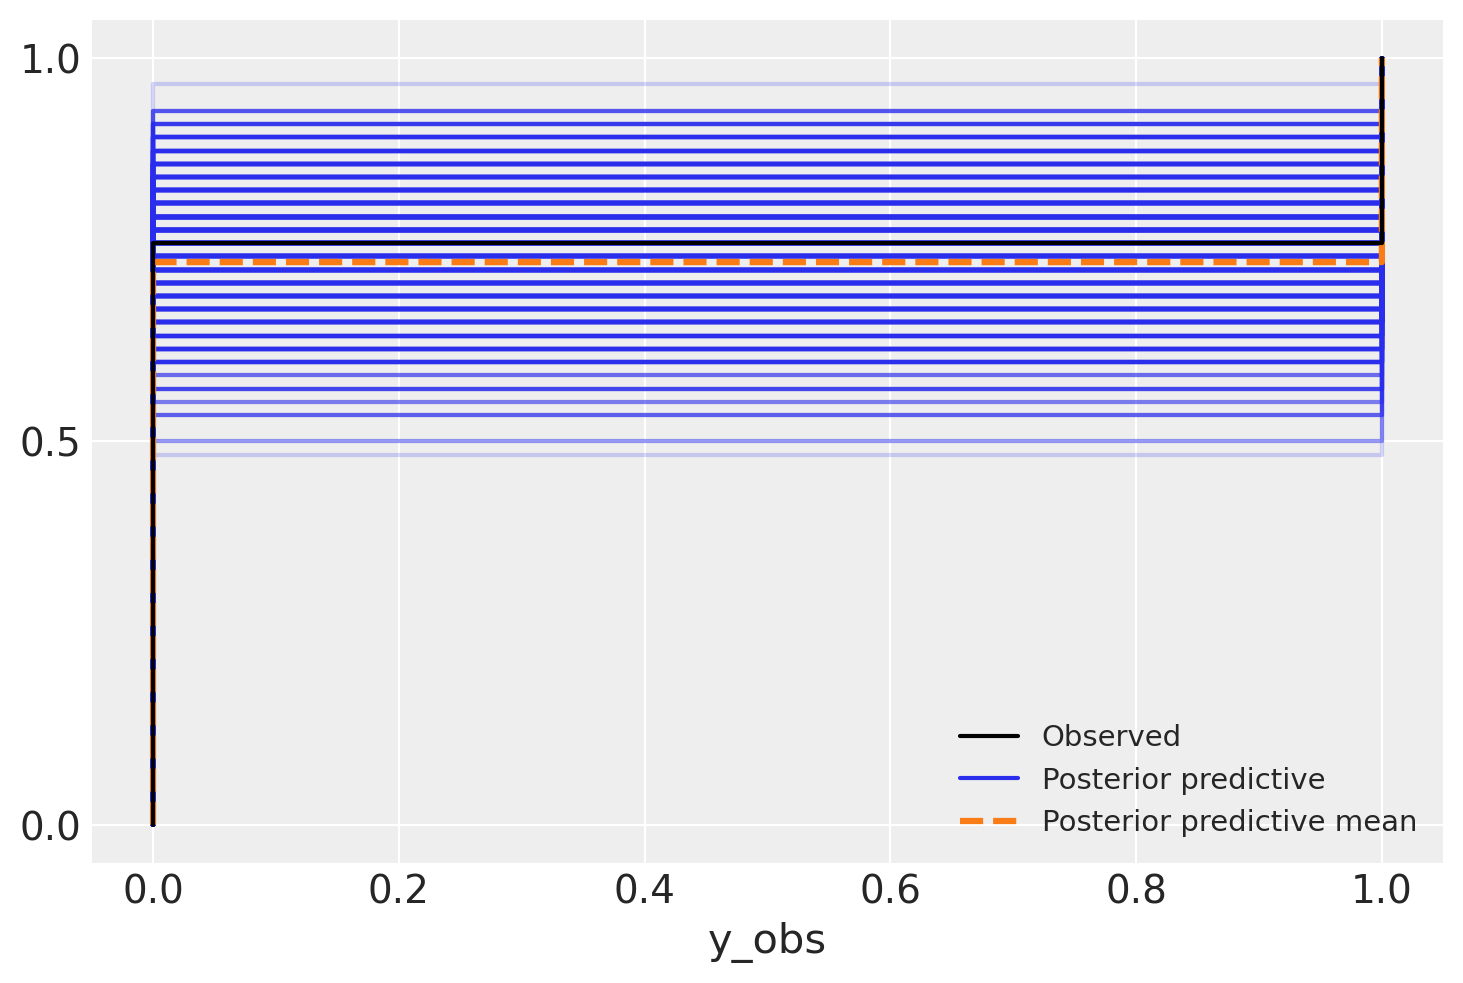

In [38]:
az.plot_ppc(trace, num_pp_samples=1000, kind = 'cumulative');

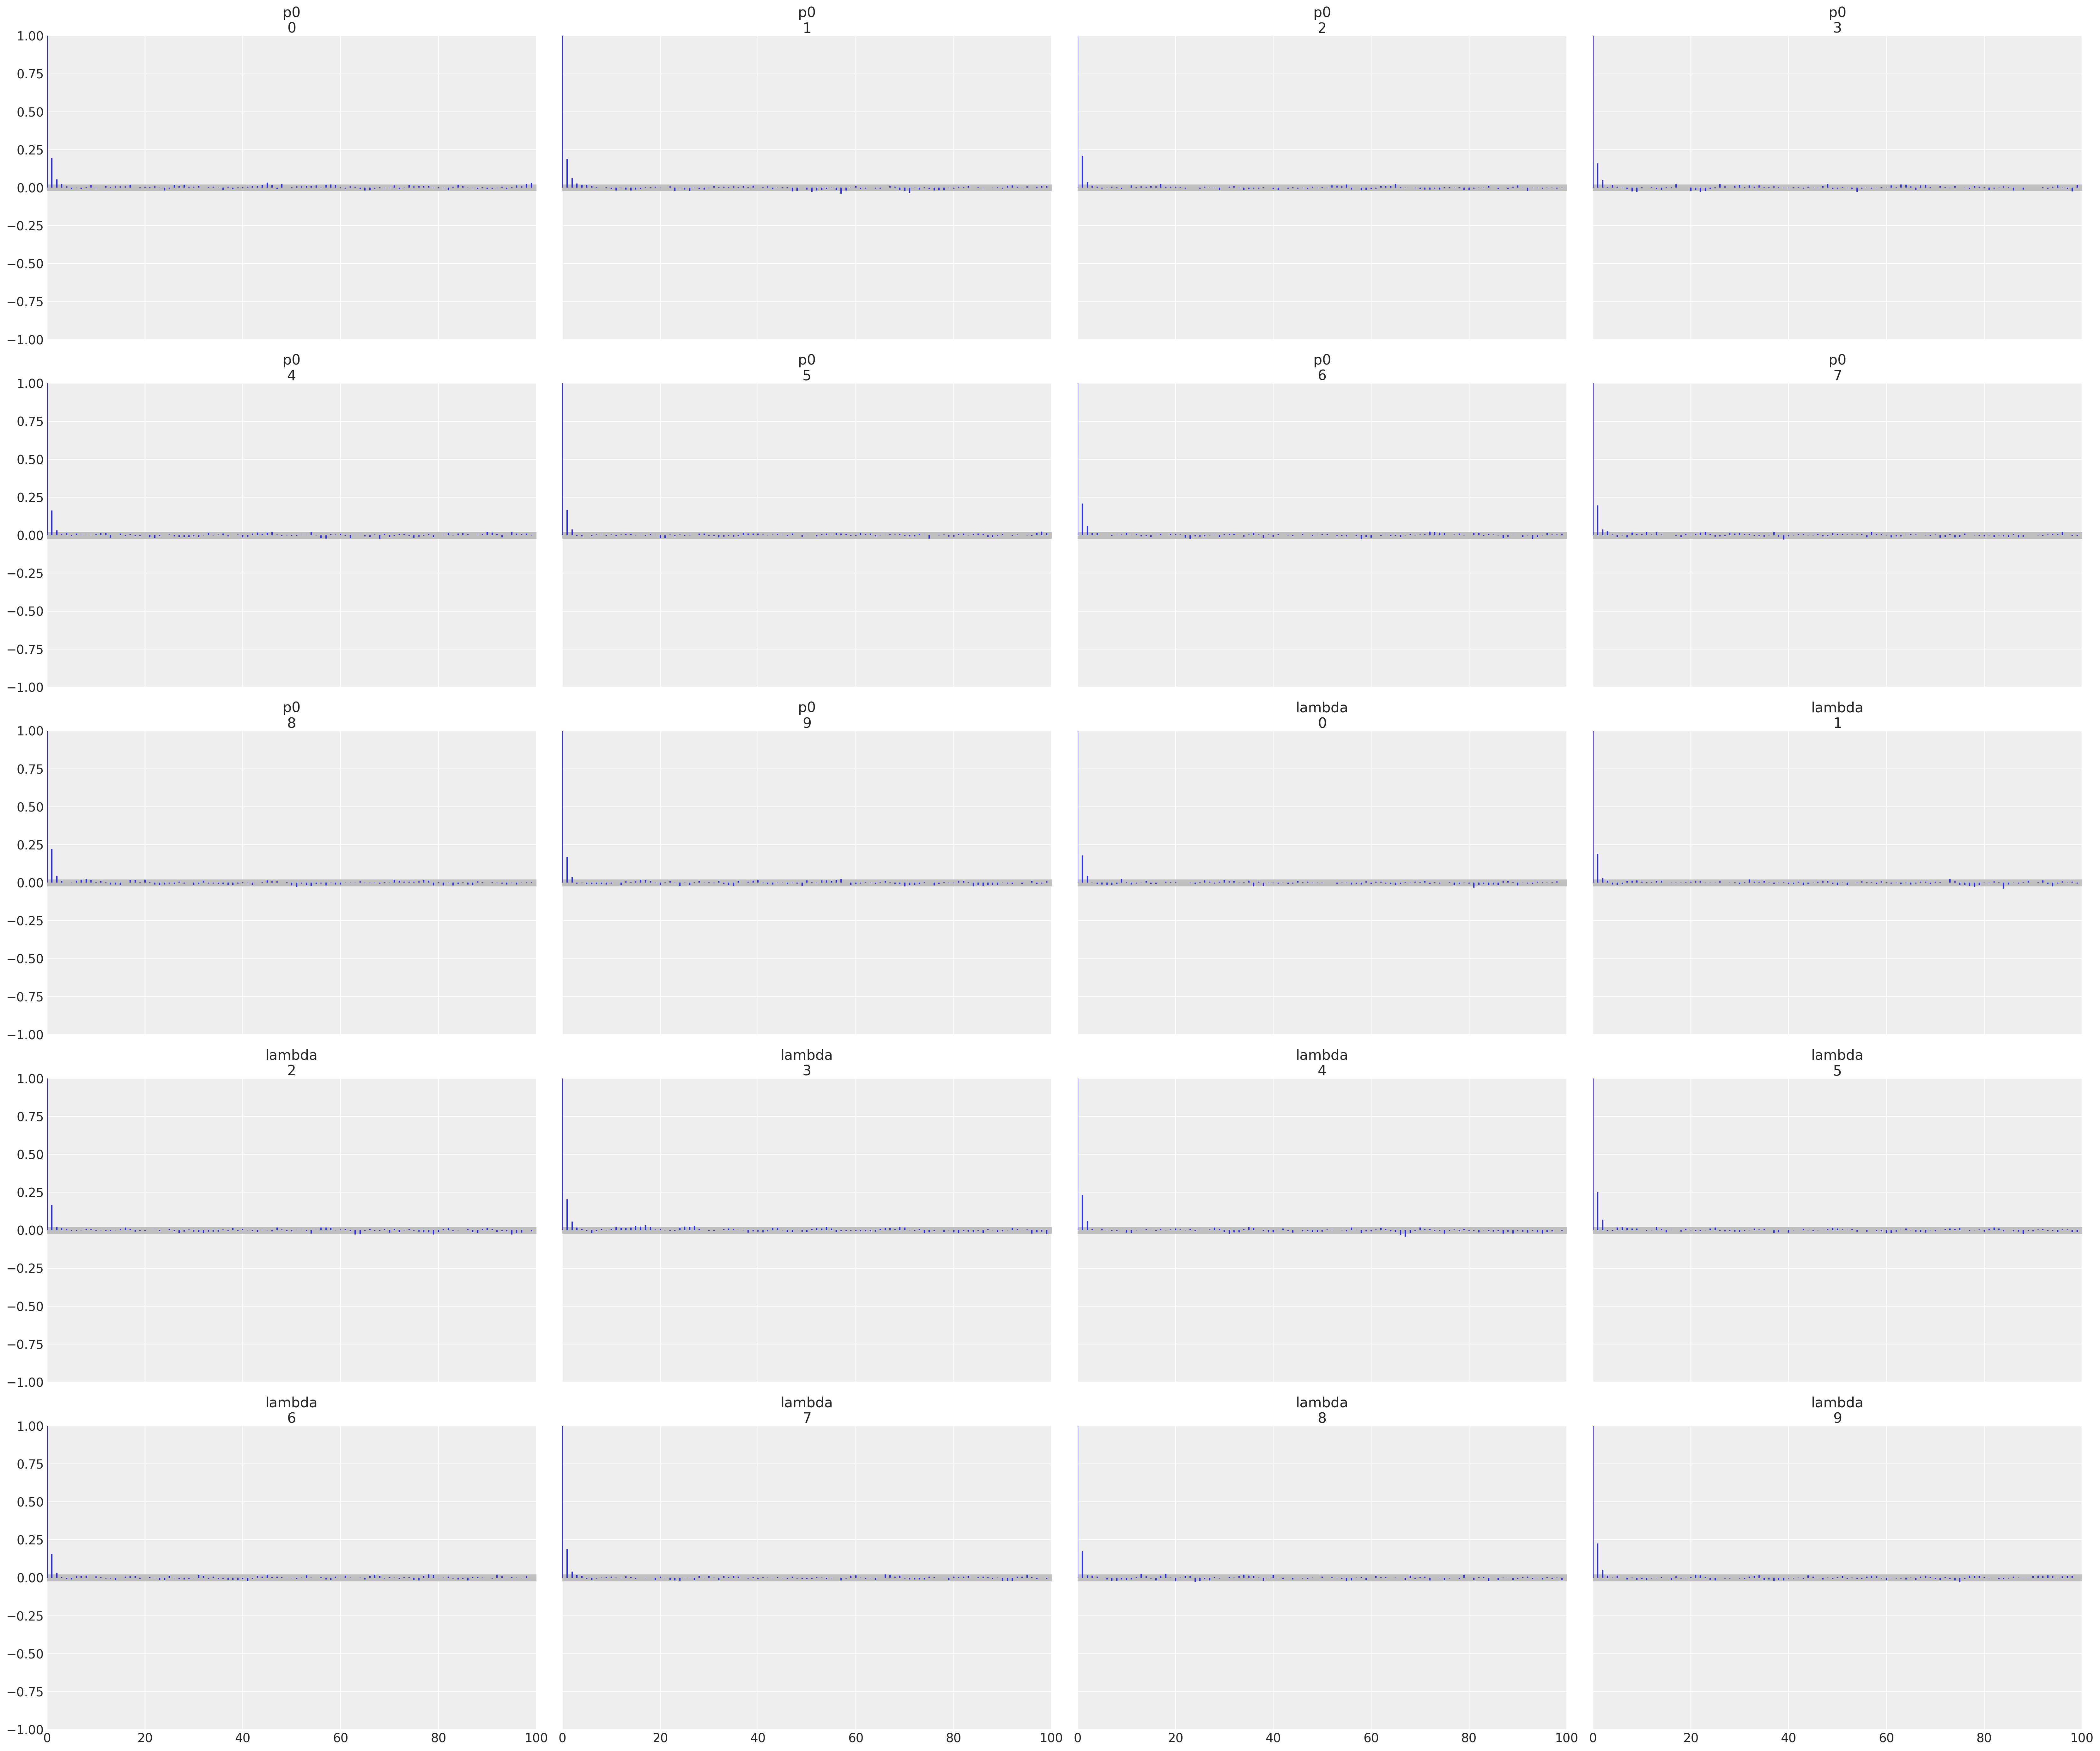

In [40]:
az.plot_autocorr(trace, var_names=["p0", "lambda"]);

In [41]:
# Gelman-Rubin convergence diagnostic
r_hat = az.rhat(trace, var_names=["p0", "lambda"])
print(r_hat)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    p0       float64 1.0
    lambda   float64 1.0


In [42]:
ess = az.ess(trace, var_names=["p0", "lambda"])

c:\Users\manhi\anaconda3\envs\tf\lib\site-packages\arviz\plots\essplot.py:205: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_draws = data.dims["draw"]
c:\Users\manhi\anaconda3\envs\tf\lib\site-packages\arviz\plots\essplot.py:206: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_samples = n_draws * data.dims["chain"]


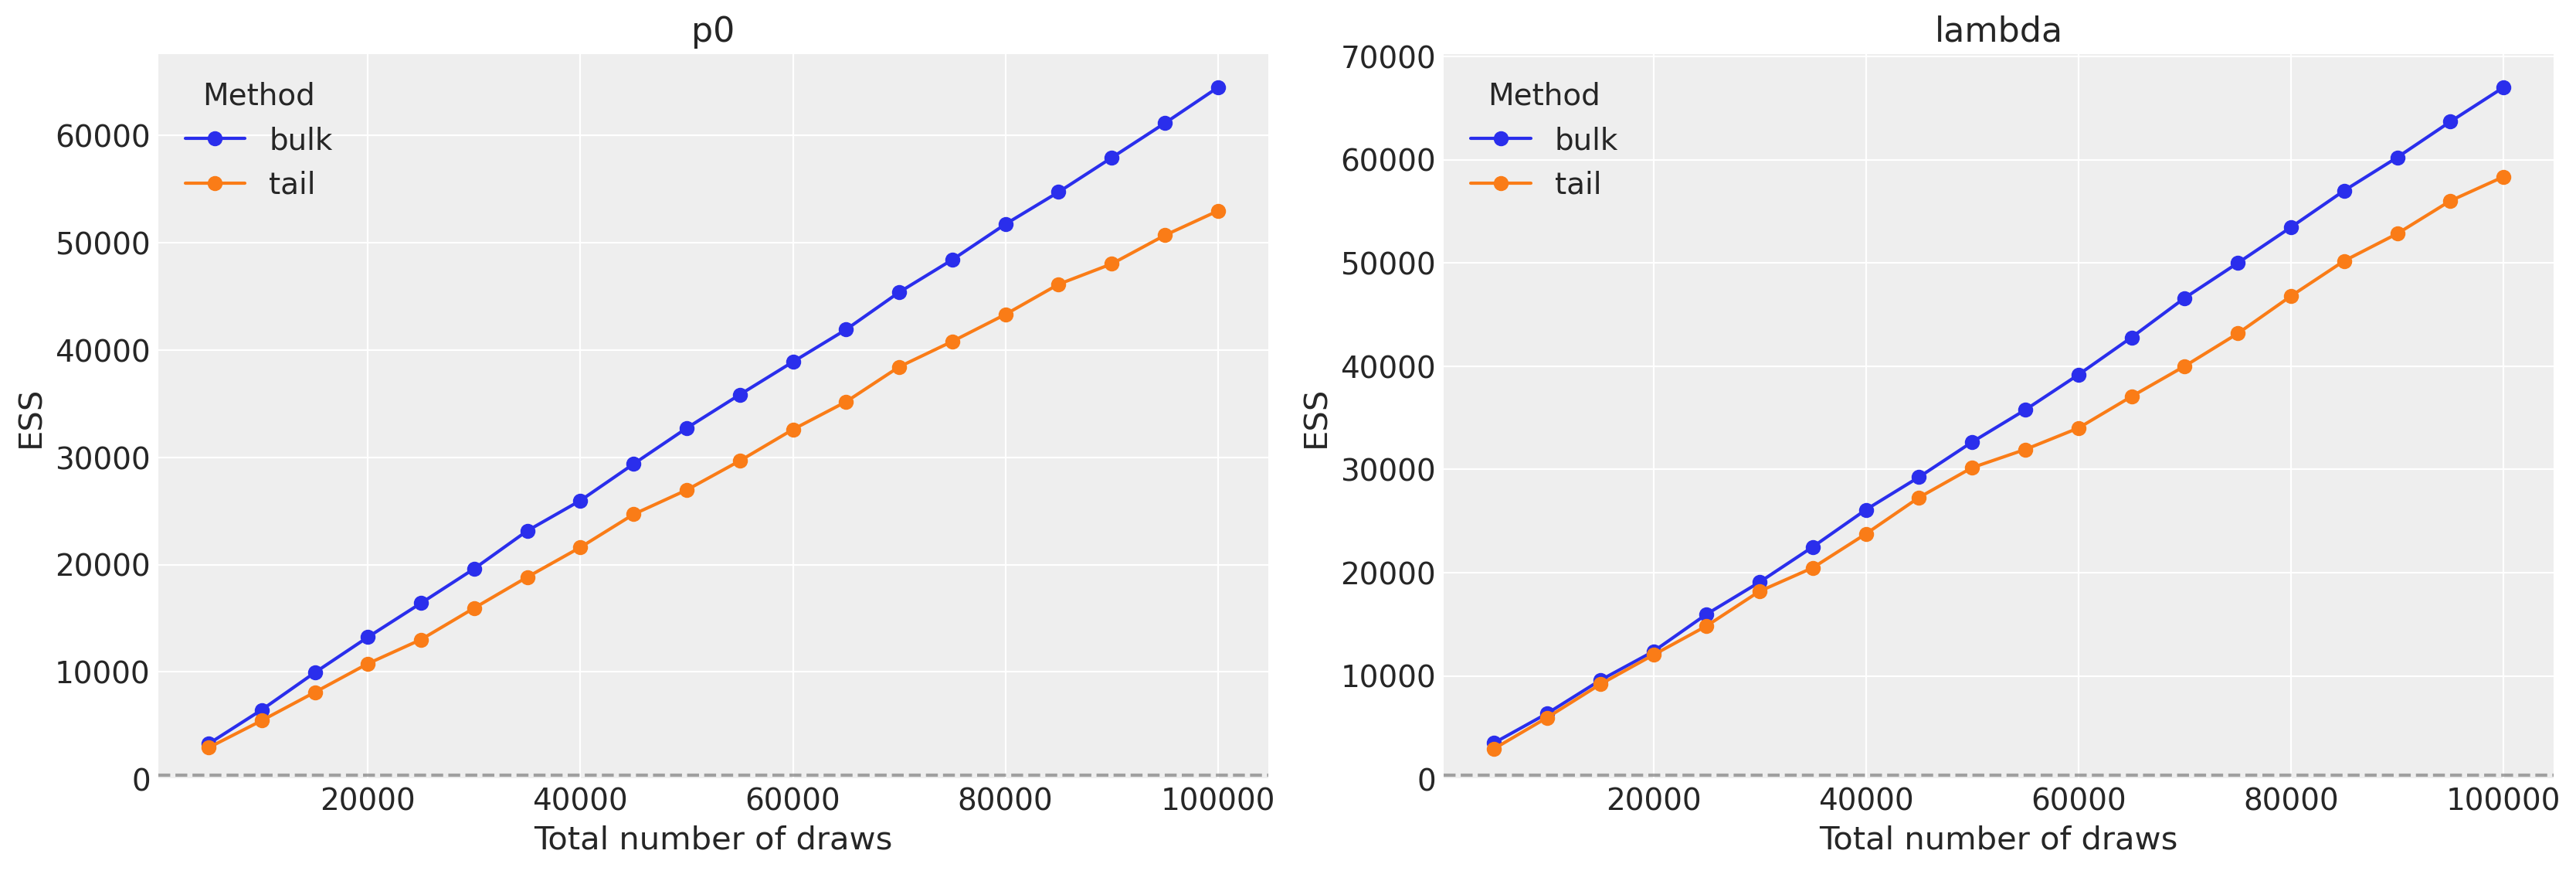

In [43]:
az.plot_ess(trace, var_names=["p0", "lambda"], kind="evolution");

In [44]:
total_ess = ess["p0"].sum().values
print(f"Total effective sample size for p0: {float(total_ess):.2f}")

Total effective sample size for p0: 64497.26


In [45]:
total_ess = ess["lambda"].sum().values
print(f"Total effective sample size for lambda: {float(total_ess):.2f}")

Total effective sample size for lambda: 66994.23
